<a href="https://colab.research.google.com/github/kiannakazemi/telco_customer_churn/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn

By analyzing the customer data, we're going to predict customer churn and provide insights that can help the Telco company develop strategies to keep their customers from leaving.

Telco Customer Churn dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

**Attribute Information:**
  1. CustomerID: A unique ID that identifies each customer
  2. Gender: The customer’s gender: Male, Female
  3. Senior Citizen: Indicates if the customer is 65 or older: Yes, No
  4. Partner: Indicates if the customer is the partner of the company: Yes, No
  5. Dependents: Indicates if the customer lives with any dependents: Yes, No Dependents could be children, parents, grandparents, etc.
  6. Tenure: Indicates the total amount of months that the customer has been with the company
  7. Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
  8. Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
  9. Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic
  10. Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
  11. Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
  12. Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
  13. Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
  14. Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No
  The company does not charge an additional fee for this service.
  15. Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No
  The company does not charge an additional fee for this service.
  16. Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year
  17. Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
  18. Payment Method: Indicates how the customer pays their bill: Electronic check, Mailed Check, Bank transfer, Credit Card
  19. Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company
  20. Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter




In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

To have a better understanding of our data, let's generate count plots for each predictor variable in the dataset to show the distribution of churned and non-churned customers within each category

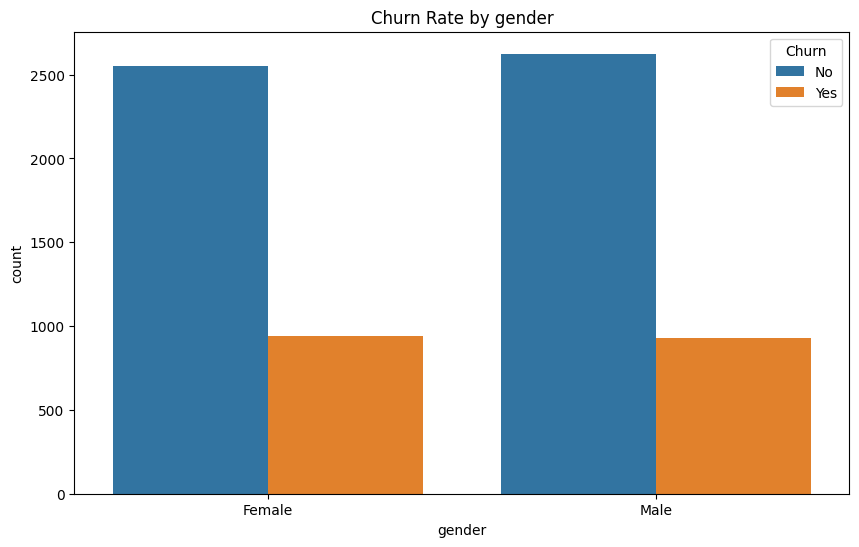

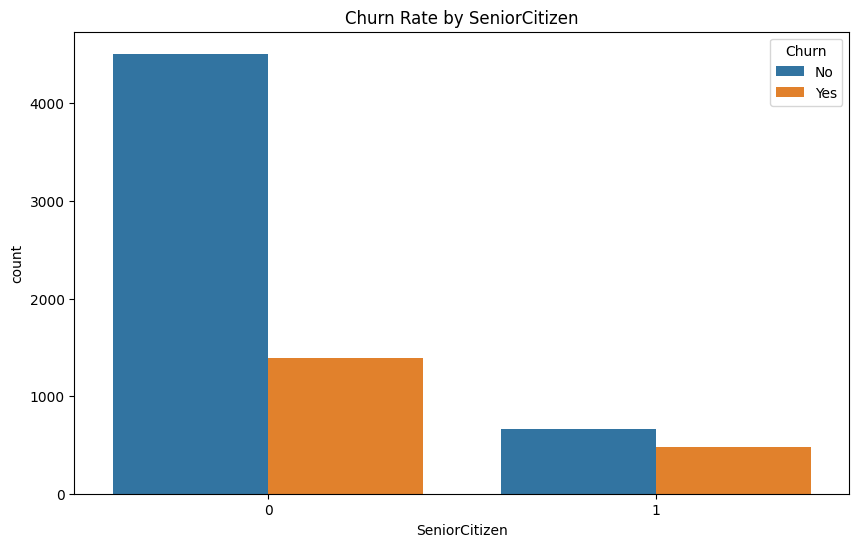

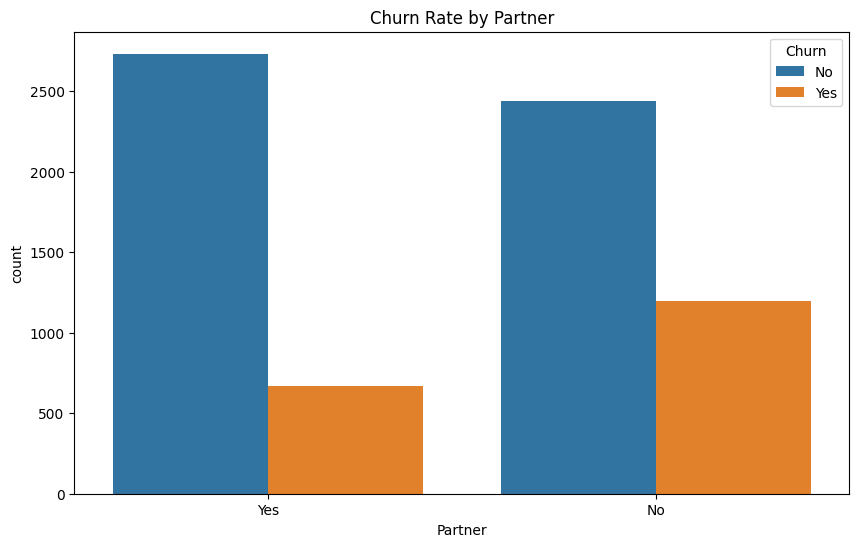

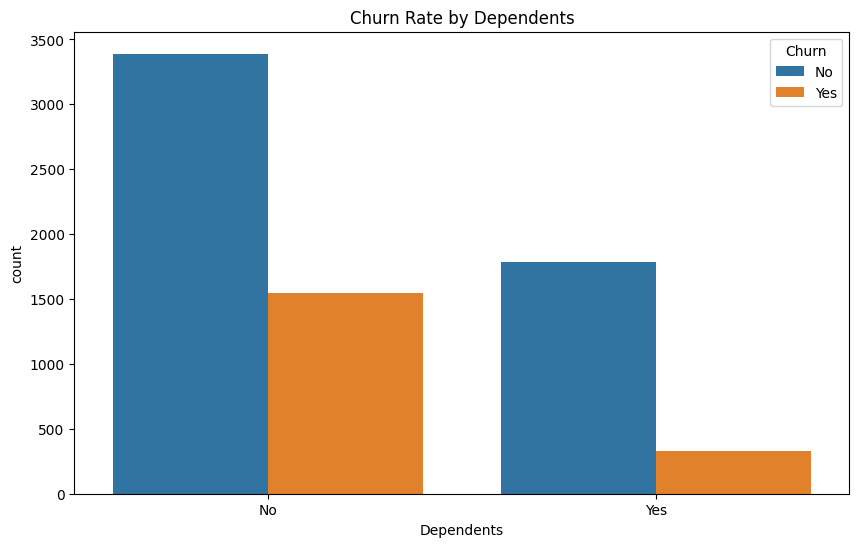

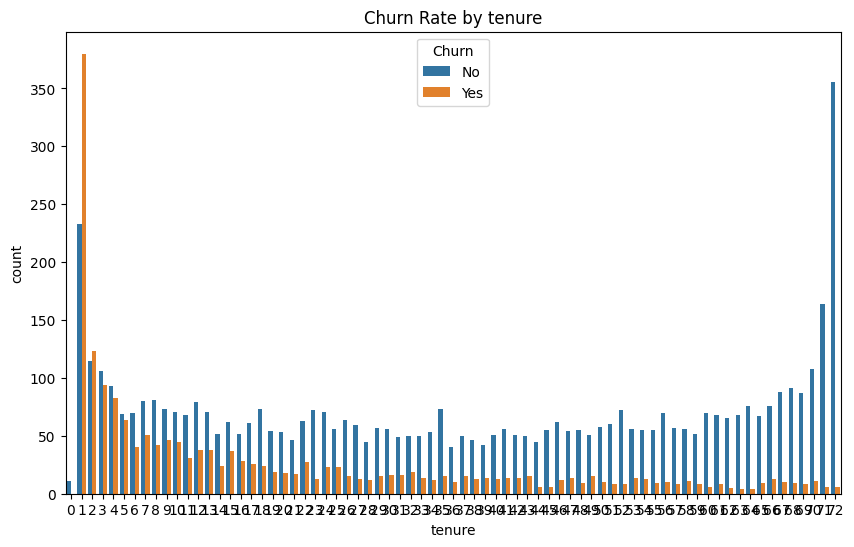

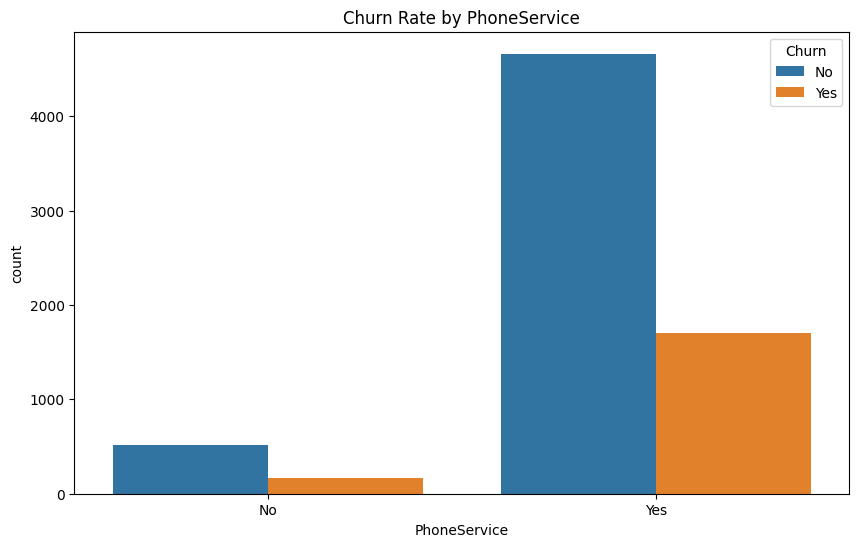

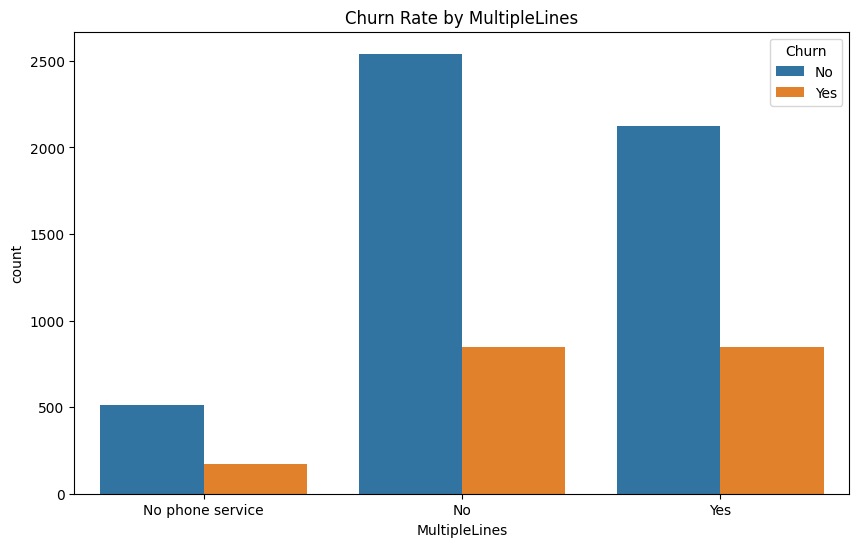

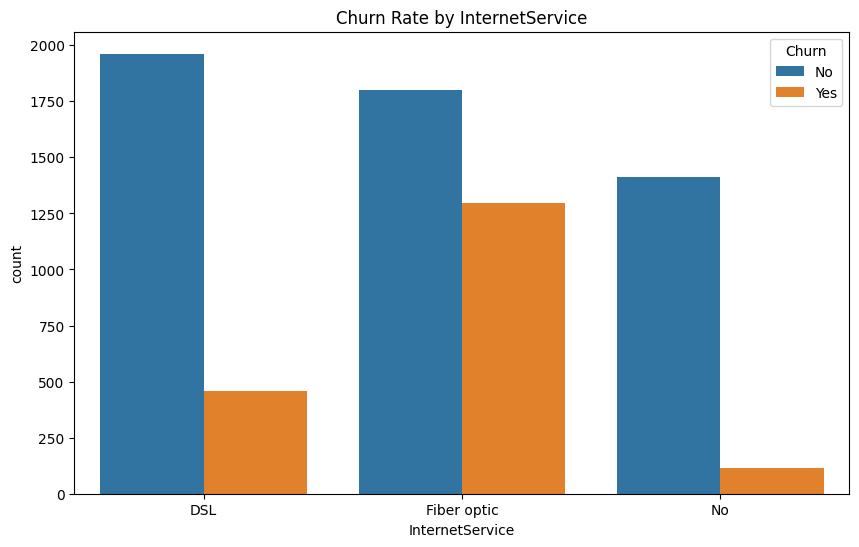

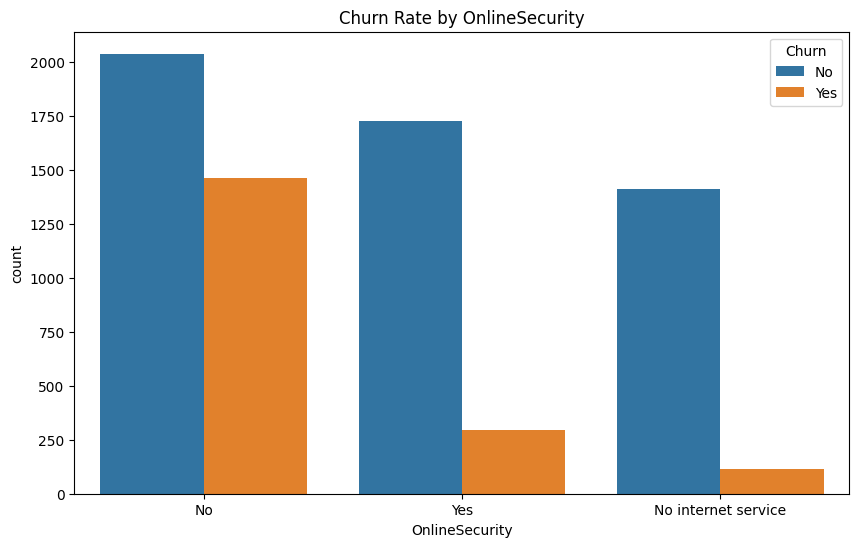

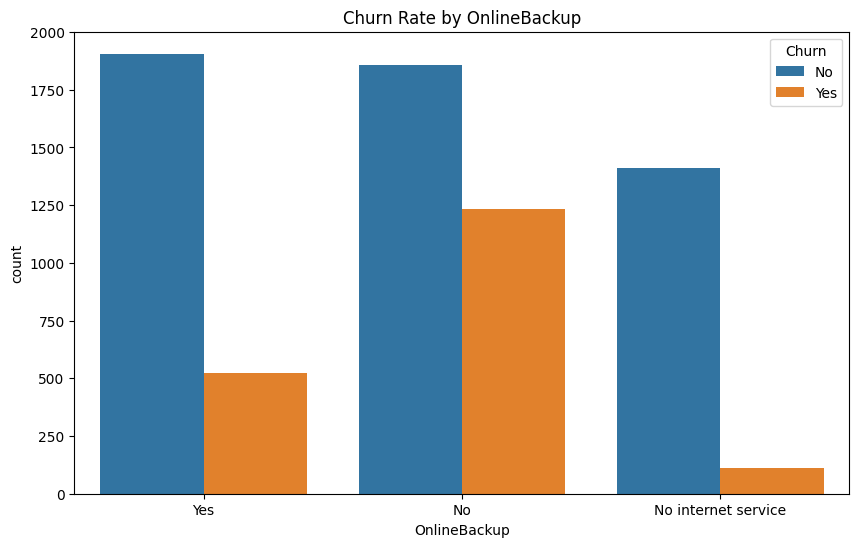

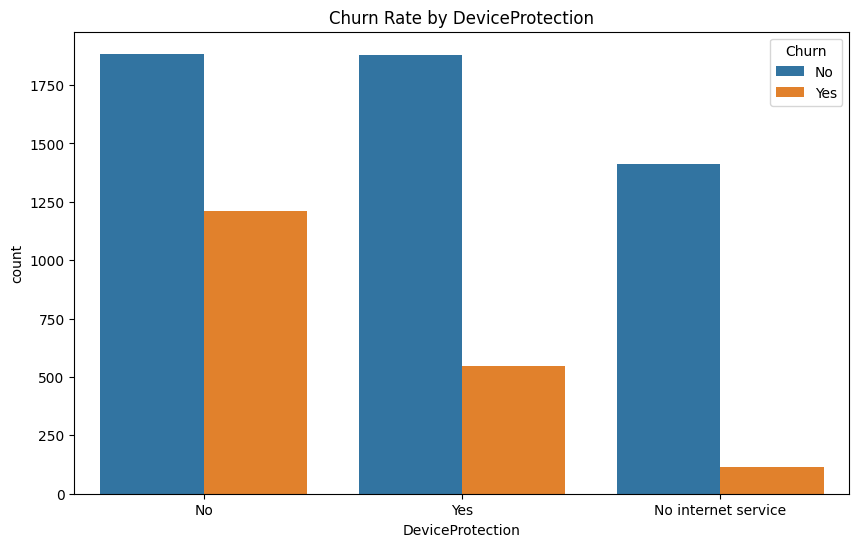

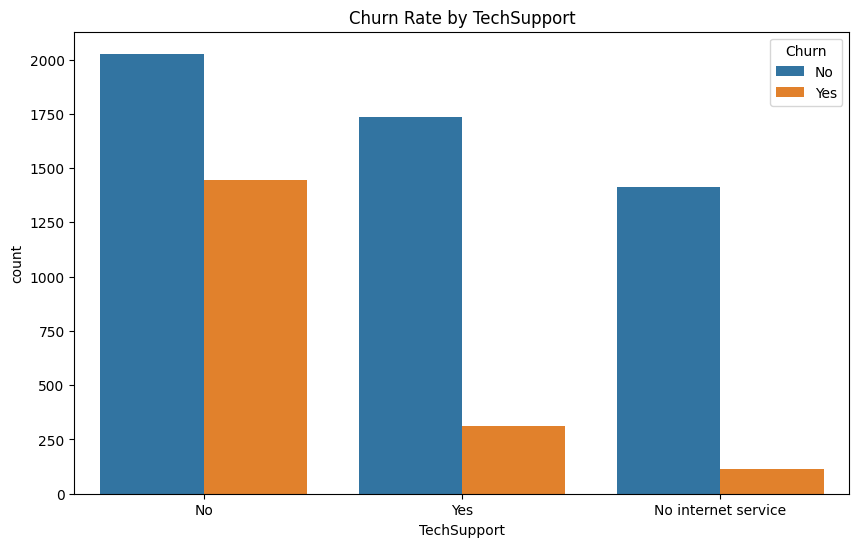

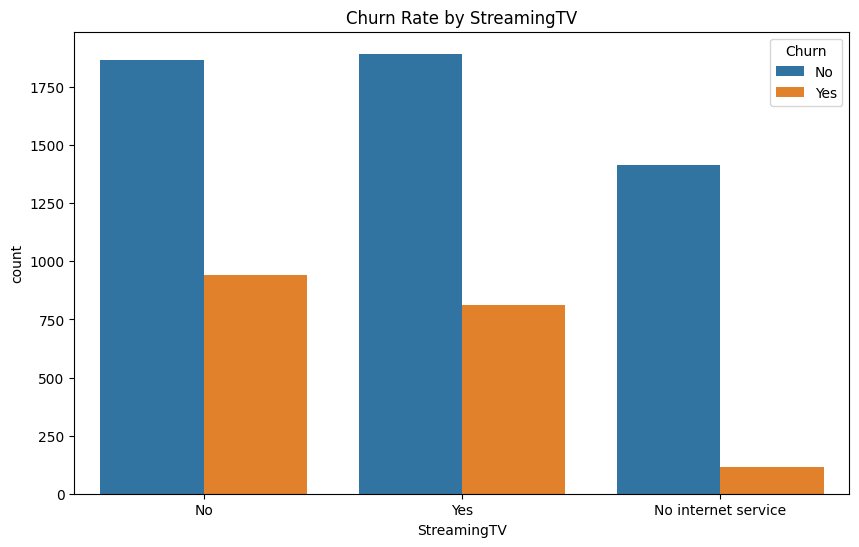

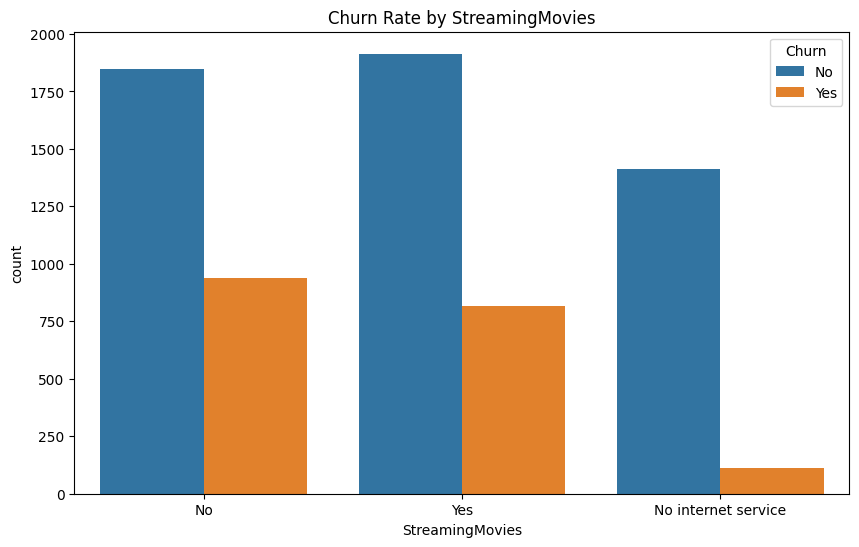

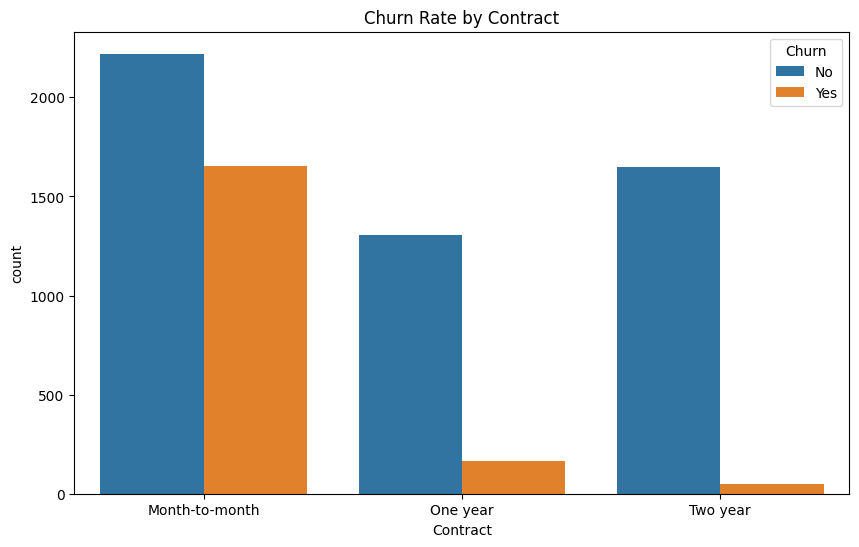

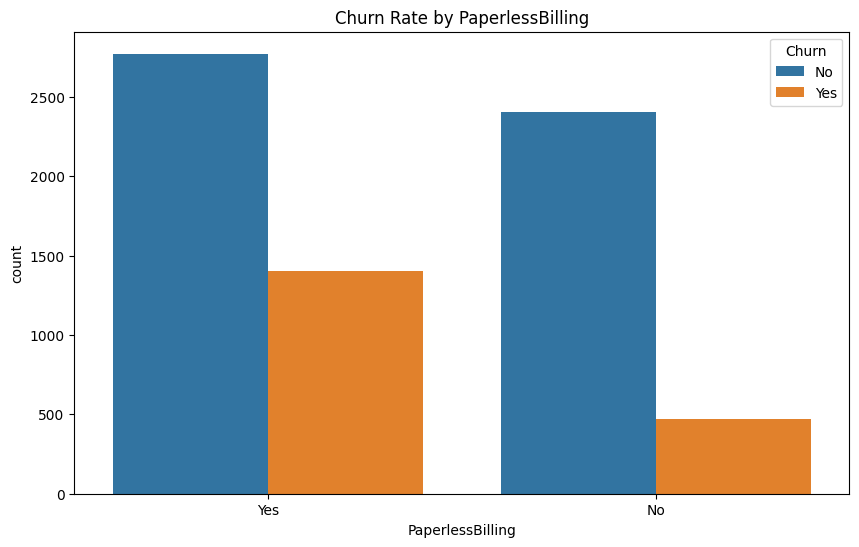

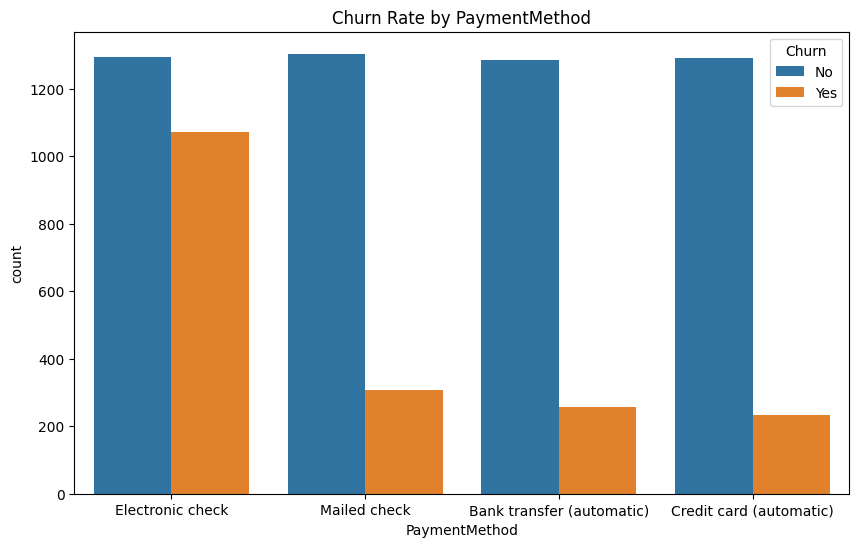

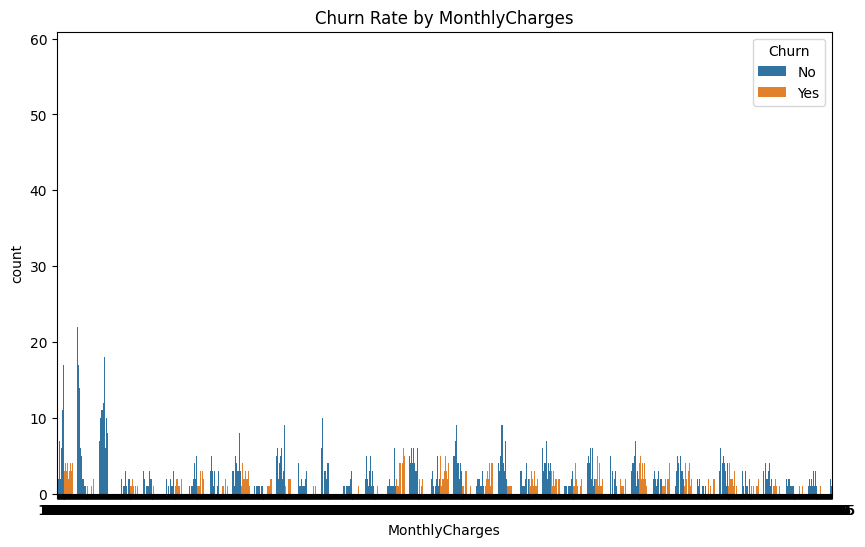

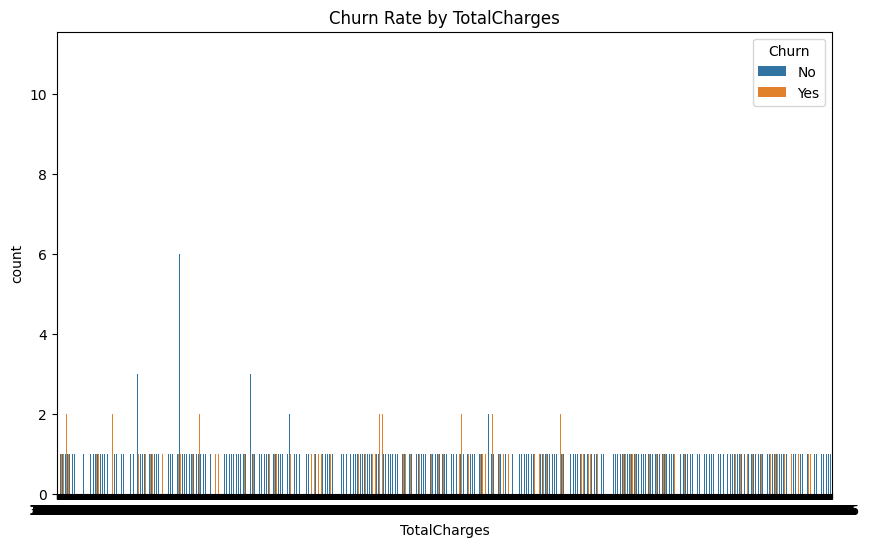

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Create a list of the predictor variables
predictor_variables = list(df.columns)
predictor_variables.remove('customerID')
predictor_variables.remove('Churn')

# Create a box plot for each predictor variable
for predictor_variable in predictor_variables:
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.countplot(x=predictor_variable, hue="Churn", data=df)
    plt.title('Churn Rate by {}'.format(predictor_variable))

    plt.show()
    print()

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#convert Female to 0 and Male to 1 for the Gender column using one-hot encoding
df['gender'] = (df['gender'] == 'Male').astype(int)

#replace all instances of 'Yes' with 1 and 'No' with 0
cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
df[cols] = df[cols].replace({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})

#use label encoding to convert InternetService categorical values to numerical: 'DSL' to 0, 'Fiber optic' to 1, and 'No' to 2
internet_service_encoder = LabelEncoder()
df['InternetService'] = internet_service_encoder.fit_transform(df['InternetService'])

#use label encoding to convert Contract categorical values to numerical: 'Month-to-month' to 0, 'One year' to 1, and 'Two year' to 2
contract_encoder = LabelEncoder()
df['Contract'] = contract_encoder.fit_transform(df['Contract'])

#use custom mapping to convert PaymentMethod categorical values to numerical
payment_method_mapping = {
    'Electronic check': 0,
    'Mailed check': 1,
    'Bank transfer (automatic)': 2,
    'Credit card (automatic)': 3
}
df['PaymentMethod'] = df['PaymentMethod'].map(payment_method_mapping)

#drop the 'customerID' column
df = df.drop('customerID', axis=1)

#replace ' ' with None in the TotalCharges column
df['TotalCharges'] = df['TotalCharges'].replace(' ', None)

#remove NaN rows
df = df.dropna()

**Train & test datasets**

In [4]:
# Splitting the dataset into features (X) and the target variable (y)
X = df.drop(['Churn'], axis=1)
y = df['Churn']

# Splitting the data into a training set (75%) and a testing set (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

As we can see in our training dataset, approximately 26% of the customers churned, while approximately 74% didn't churn. This significant imbalance might become an issue; therefore, we're going to oversample the dataset.

In [5]:
print(y_train.value_counts(normalize=True))

0    0.732461
1    0.267539
Name: Churn, dtype: float64


In [6]:
# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts(normalize=True))

0    0.5
1    0.5
Name: Churn, dtype: float64


Scale the data to ensure that all of the features have the same importance to the model

In [7]:
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**Random Forests**

In [8]:
# Tune the hyperparameters of the Random Forest model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled_scaled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)
accuracy = best_model.score(X_test_scaled, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.7263936291240045
